# Air Fare Prediction

### Import Libraries

In [1]:
# Import Libraries
import pandas as pd
import os
from category_encoders import QuantileEncoder, WOEEncoder, JamesSteinEncoder, OneHotEncoder
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.formula.api as smf
from statsmodels.regression.quantile_regression import QuantReg
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
import scipy.stats
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

from tensorflow.keras import regularizers
from keras import layers, datasets, models
from keras.models import Model
import tensorflow as tf

In [2]:
os.chdir("C:\\MS in Data Science\\IIT\\Courses\\MATH 564 - Applied Statistics\\Project\\DB1B dataset")

### Load Datasets

In [3]:
# Load the datasets
ticket = pd.read_csv("T_DB1B_TICKET.csv")
market = pd.read_csv("T_DB1B_MARKET.csv")
coupon = pd.read_csv("T_DB1B_COUPON.csv")
print(ticket.shape)
print(market.shape)
print(coupon.shape)

(4194304, 14)
(2097152, 14)
(2097152, 5)


### Data Prep

#### Analyse data

#### Merge datasets

In [4]:
# Create a subset of the ticket dataset with necessary columns
ticket_sub = ticket.drop(['ORIGIN_AIRPORT_ID', 
                          'ORIGIN_CITY_MARKET_ID',
                           'ORIGIN_COUNTRY',
                          'ITIN_FARE',
                          'DISTANCE',
                          'MILES_FLOWN',
                           'ITIN_GEO_TYPE',
                          'PASSENGERS'
                          ], axis=1)
print(market.shape)
print(ticket_sub.shape)
print(coupon.shape)

(2097152, 14)
(4194304, 6)
(2097152, 5)


In [5]:
# Merge the 3 datasets
data = pd.merge(market, ticket_sub, on='ITIN_ID', how='inner')
data = pd.merge(data, coupon, on=['ITIN_ID', 'ORIGIN_AIRPORT_ID'], how='left')
data.shape

(2102817, 22)

In [6]:
# Check for null values
data.isna().sum()

ITIN_ID                        0
ORIGIN_AIRPORT_ID              0
ORIGIN_CITY_MARKET_ID          0
DEST_AIRPORT_ID                0
DEST_CITY_MARKET_ID            0
TICKET_CARRIER                 0
OPERATING_CARRIER              0
PASSENGERS                     0
MARKET_FARE                    0
MARKET_DISTANCE                0
DISTANCE_GROUP                 0
MARKET_MILES_FLOWN             0
ITIN_GEO_TYPE                  0
MKT_GEO_TYPE                   0
ORIGIN_STATE_ABR               0
ROUNDTRIP                      0
ONLINE                         0
DOLLAR_CRED                    0
BULK_FARE                      0
TRIP_BREAK               1488041
COUPON_TYPE               764687
FARE_CLASS                776271
dtype: int64

#### Clean data

In [7]:
# Convert categorical variables to object type
Y = 'MARKET_FARE'
int_cols = ['PASSENGERS', 'MARKET_FARE', 'MARKET_DISTANCE', 'MARKET_MILES_FLOWN', 'ONLINE', 'ROUNDTRIP']
for col in data.columns:
    if col not in int_cols:
        data.loc[:, col] = data.loc[:, col].astype('object')

In [8]:
# Clean null values
data = data.loc[~data['FARE_CLASS'].isna()]
data.loc[data['TRIP_BREAK'].isna(), 'TRIP_BREAK'] = '-99'
data.loc[data['COUPON_TYPE'].isna(), 'COUPON_TYPE'] = '-99'
data.loc[data['FARE_CLASS'].isna(), 'FARE_CLASS'] = '-99'

# Group categories of Fare Class based on business/economy/first class
data.loc[data['FARE_CLASS'].isin(['G', 'F', 'C']), 'FARE_CLASS'] = 'D'
data.loc[data['FARE_CLASS'].isin(['U', 'Y']), 'FARE_CLASS'] = 'X'

data.loc[data['COUPON_TYPE'] == 'D', 'COUPON_TYPE'] = '-99'
data = data.loc[data['DOLLAR_CRED']==1]

# Create categories of different operating carriers based on their mean value
op_df = data.groupby('OPERATING_CARRIER')['MARKET_FARE'].agg(['count', 'mean']).reset_index()
op_a = op_df.loc[(op_df['mean']<=300), 'OPERATING_CARRIER'].tolist()
op_b = op_df.loc[(op_df['mean']>300), 'OPERATING_CARRIER'].tolist()
data.loc[data['OPERATING_CARRIER'].isin(op_a), 'OPERATING_CARRIER'] = 'A'
data.loc[data['OPERATING_CARRIER'].isin(op_b), 'OPERATING_CARRIER'] = 'B'

# Drop variables
data = data.drop(['ITIN_GEO_TYPE', 'DOLLAR_CRED', 'BULK_FARE', 'ITIN_ID',
                 'ORIGIN_CITY_MARKET_ID', 'DEST_CITY_MARKET_ID', 'DISTANCE_GROUP', 'MARKET_MILES_FLOWN',
                  'TICKET_CARRIER'
                 ], axis=1)

data.shape

(1319376, 13)

#### Outliers

In [12]:
# Price cant be <50 (ignoring discounts)
data = data[data[Y]>=50]
data.loc[data[Y]>np.quantile(data[Y], 0.99), Y] = np.quantile(data[Y], 0.99) # Capping price value at 99th percentile

# Capping Distance at 1st and 99th percentiles
data.loc[data['MARKET_DISTANCE']>np.quantile(data['MARKET_DISTANCE'], 0.99), 'MARKET_DISTANCE'] = np.quantile(data['MARKET_DISTANCE'], 0.99)
data.loc[data['MARKET_DISTANCE']<np.quantile(data['MARKET_DISTANCE'], 0.01), 'MARKET_DISTANCE'] = np.quantile(data['MARKET_DISTANCE'], 0.01)

# Capping Passengers at 1st and 99th percentiles
data.loc[data['PASSENGERS']>np.quantile(data['PASSENGERS'], 0.99), 'PASSENGERS'] = np.quantile(data['PASSENGERS'], 0.99)
data.loc[data['PASSENGERS']<np.quantile(data['PASSENGERS'], 0.01), 'PASSENGERS'] = np.quantile(data['PASSENGERS'], 0.01)

#### Quantile encoding

In [13]:
# Quantile encoding for 
enc_cols = ['ORIGIN_AIRPORT_ID', 
            'DEST_AIRPORT_ID',
           'OPERATING_CARRIER',
            'FARE_CLASS',
            'ORIGIN_STATE_ABR',
            'MKT_GEO_TYPE', 'TRIP_BREAK', 'COUPON_TYPE'
                           ]

enc = QuantileEncoder(cols=enc_cols, quantile=0.5, m=1)
enc.fit(data.drop(Y, axis=1), data[Y])
data_t = enc.transform(data.drop(Y, axis=1))
data_t[Y] = data.loc[:, Y]
data = data_t.copy()
del(data_t)
data.head()

,ORIGIN_AIRPORT_ID,DEST_AIRPORT_ID,OPERATING_CARRIER,PASSENGERS,MARKET_DISTANCE,MKT_GEO_TYPE,ORIGIN_STATE_ABR,ROUNDTRIP,ONLINE,TRIP_BREAK,COUPON_TYPE,FARE_CLASS,MARKET_FARE
1,246.504736,250.003085,218.500574,1.0,470.0,281.000005,249.502827,0.0,1.0,258.500048,287.0,274.500011,59.0
2,246.504736,250.003085,218.500574,12.0,470.0,281.000005,249.502827,0.0,1.0,258.500048,287.0,274.500011,67.0
3,246.504736,250.003085,218.500574,12.0,470.0,281.000005,249.502827,0.0,1.0,258.500048,287.0,274.500011,79.0
4,246.504736,250.003085,218.500574,1.0,470.0,281.000005,249.502827,0.0,1.0,258.500048,287.0,274.500011,80.0
5,246.504736,250.003085,218.500574,4.0,470.0,281.000005,249.502827,0.0,1.0,258.500048,287.0,274.500011,90.0


#### Mulitcollinearity

<AxesSubplot: >

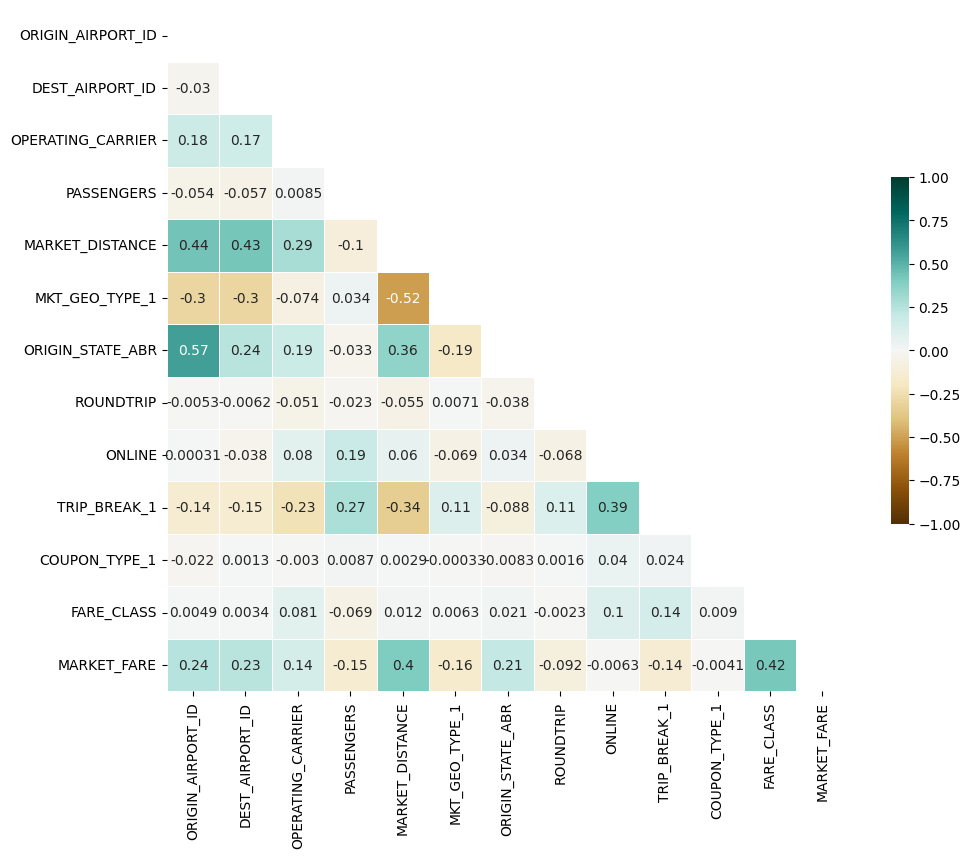

In [101]:
cor_df = data.corr()
mask = np.triu(np.ones_like(cor_df, dtype=bool))
f, ax = plt.subplots(figsize=(11, 9))
#cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(cor_df, mask=mask, cmap='BrBG', vmin=-1, vmax=1, center=0, annot=True,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [15]:
# Remove ORIGIN_STATE_ABR as it is highly correlated
data = data.drop(['ORIGIN_STATE_ABR'], axis=1)


KeyError: "['ORIGIN_STATE_ABR'] not found in axis"

#### Normalize

In [21]:
# Normalize
norm_cols = ['ORIGIN_AIRPORT_ID', 'DEST_AIRPORT_ID', 'OPERATING_CARRIER', 'PASSENGERS', 'MARKET_DISTANCE', 'FARE_CLASS', 'MKT_GEO_TYPE', 'TRIP_BREAK', 'COUPON_TYPE']
minmax = MinMaxScaler()
minmax.fit(data[norm_cols])
X_norm = minmax.transform(data[norm_cols])
i =0
for col in norm_cols:
    data.loc[:,col] = X_norm[:,i]
    i = i+ 1
data.head()

,ORIGIN_AIRPORT_ID,DEST_AIRPORT_ID,OPERATING_CARRIER,PASSENGERS,MARKET_DISTANCE,MKT_GEO_TYPE,ROUNDTRIP,ONLINE,TRIP_BREAK,COUPON_TYPE,FARE_CLASS,MARKET_FARE
0,0.184342,0.151529,0.0,0.000000,0.055744,0.0,0.0,1.0,0.0,0.0,0.0,59.0
1,0.184342,0.151529,0.0,1.000000,0.055744,0.0,0.0,1.0,0.0,0.0,0.0,67.0
2,0.184342,0.151529,0.0,1.000000,0.055744,0.0,0.0,1.0,0.0,0.0,0.0,79.0
3,0.184342,0.151529,0.0,0.000000,0.055744,0.0,0.0,1.0,0.0,0.0,0.0,80.0
4,0.184342,0.151529,0.0,0.272727,0.055744,0.0,0.0,1.0,0.0,0.0,0.0,90.0


### Split into Test Train


In [22]:
x_train, x_test, y_train, y_test = train_test_split(data.drop(Y, axis=1), data[Y], test_size=0.2, random_state=10)
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(938604, 11)
(234651, 11)
(938604,)
(234651,)


### Model Building

#### Linear Model

In [23]:
# OLS
X = sm.add_constant(x_train)
ols = sm.OLS(y_train, X)
results = ols.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            MARKET_FARE   R-squared:                       0.395
Model:                            OLS   Adj. R-squared:                  0.395
Method:                 Least Squares   F-statistic:                 5.564e+04
Date:                Wed, 30 Nov 2022   Prob (F-statistic):               0.00
Time:                        18:29:43   Log-Likelihood:            -5.7860e+06
No. Observations:              938604   AIC:                         1.157e+07
Df Residuals:                  938592   BIC:                         1.157e+07
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const               121.8336      0.713    170.793      0.000     120.435     123.232
ORIGIN_AIRPORT_ID   221.8416      1.483    149.570      0.000     218.935     224.749
DEST_AIRPORT_ID     287.2303      1.997    143.860      0.000     283.317     291.144
OPERATING_CARRIER    -5.0671      0.440    -11.505      0.000      -5.930      -4.204
PASSENGERS          -74.1311      0.870    -85.197      0.000     -75.836     -72.426
MARKET_DISTANCE     278.7508      0.967    288.147      0.000     276.855     280.647
MKT_GEO_TYPE        -52.1967      0.656    -79.592      0.000     -53.482     -50.911
ROUNDTRIP           -14.6512      0.270    -54.221      0.000     -15.181     -14.122
ONLINE              -13.1098      0.289    -45.354      0.000     -13.676     -12.543
TRIP_BREAK            9.5724      0.301     31.832      0.000       8.983      10.162
COUPON_TYPE          32.5734      9.461      3.443      0.001      14.030      51.117
FARE_CLASS          256.9667      0.483    532.536      0.000     256.021     257.912
==============================================================================
Omnibus:                    50587.994   Durbin-Watson:                   1.995
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            59172.862
Skew:                           0.600   Prob(JB):                         0.00
Kurtosis:                       3.273   Cond. No.                         146.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [31]:
# Get predictions for test set
X_test = sm.add_constant(x_test)
ols_preds = results.predict(X_test)
print(np.sqrt(mean_squared_error(y_test, ols_preds)))
print(np.sqrt(mean_squared_error(y_train, results.fittedvalues)))

153.03769980389924
153.0393812263213


##### Cooks Distance

In [19]:
# Use Cooks distance to remove predictor outliers for the whole data
X = sm.add_constant(data.drop(Y, axis=1))
ols = sm.OLS(data[Y], X)
results = ols.fit()

# Get cooks distance
influence = results.get_influence()
cooks_distances = influence.cooks_distance

# Remove outliers
ind = np.where(~(cooks_distances[0]>3*np.mean(cooks_distances[0])))
print(data.shape[0]-ind[0].shape[0])
data = data.reset_index(drop=True)
data = data.loc[ind[0],:]

# Retrain the model
x_train, x_test, y_train, y_test = train_test_split(data.drop(Y, axis=1), data[Y], test_size=0.2, random_state=10)
X = sm.add_constant(x_train)
ols = sm.OLS(y_train, X)
results = ols.fit()
results.summary()


91474


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            MARKET_FARE   R-squared:                       0.395
Model:                            OLS   Adj. R-squared:                  0.395
Method:                 Least Squares   F-statistic:                 5.564e+04
Date:                Wed, 30 Nov 2022   Prob (F-statistic):               0.00
Time:                        18:29:05   Log-Likelihood:            -5.7860e+06
No. Observations:              938604   AIC:                         1.157e+07
Df Residuals:                  938592   BIC:                         1.157e+07
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const               -74.9593     82.632     -0.907      0.364    -236.914      86.996
ORIGIN_AIRPORT_ID   431.8841      2.888    149.570      0.000     426.225     437.543
DEST_AIRPORT_ID     463.1143      3.219    143.860      0.000     456.805     469.424
OPERATING_CARRIER    -5.0671      0.440    -11.505      0.000      -5.930      -4.204
PASSENGERS          -74.1311      0.870    -85.197      0.000     -75.836     -72.426
MARKET_DISTANCE     278.7508      0.967    288.147      0.000     276.855     280.647
MKT_GEO_TYPE         -0.4811      0.006    -79.592      0.000      -0.493      -0.469
ROUNDTRIP           -14.6512      0.270    -54.221      0.000     -15.181     -14.122
ONLINE              -13.1098      0.289    -45.354      0.000     -13.676     -12.543
TRIP_BREAK            0.1841      0.006     31.832      0.000       0.173       0.195
COUPON_TYPE           0.9909      0.288      3.443      0.001       0.427       1.555
FARE_CLASS          256.9667      0.483    532.536      0.000     256.021     257.912
==============================================================================
Omnibus:                    50587.994   Durbin-Watson:                   1.995
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            59172.862
Skew:                           0.600   Prob(JB):                         0.00
Kurtosis:                       3.273   Cond. No.                     3.45e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.45e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [20]:
# Get predictions for test set
X_test = sm.add_constant(x_test)
ols_preds = results.predict(X_test)

print("Train MSE: ", np.sqrt(mean_squared_error(y_train, results.fittedvalues)))
print("Test MSE: ", np.sqrt(mean_squared_error(y_test, ols_preds)))

Train MSE:  115.06600011092424
Test MSE:  114.98648831913569


##### Studentized deleted residuals

In [38]:
# Use Studentized deleted residuals to remove response outliers for the whole data
X = sm.add_constant(data.drop(Y, axis=1))
ols = sm.OLS(data[Y], X)
results = ols.fit()

ind = results.get_influence().get_resid_studentized_external()
ind = np.where(ind[ind<3])
data = data.reset_index(drop=True)
data = data.loc[ind[0],:]
print(1173255 - data.shape[0])

x_train, x_test, y_train, y_test = train_test_split(data.drop(Y, axis=1), data[Y], test_size=0.2, random_state=10)
X = sm.add_constant(x_train)
ols = sm.OLS(y_train, X)
results = ols.fit()
results.summary()

6559

In [41]:
X_test = sm.add_constant(x_test)
ols_preds = results.predict(X_test)

print("Train MSE: ", np.sqrt(mean_squared_error(y_train, results.fittedvalues)))
print("Test MSE: ", np.sqrt(mean_squared_error(y_test, ols_preds)))

Train MSE:  114.85995515558632
Test MSE:  114.81489774291128


##### QQ Plot

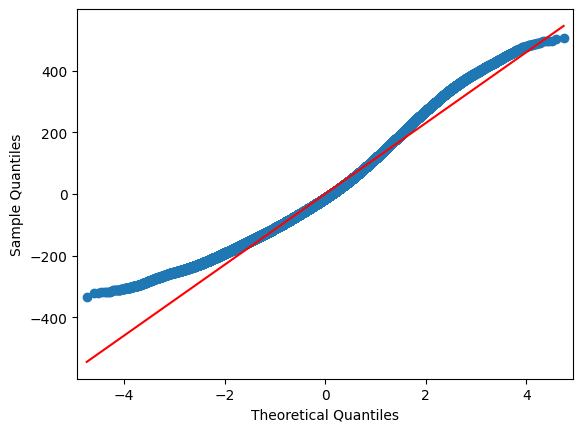

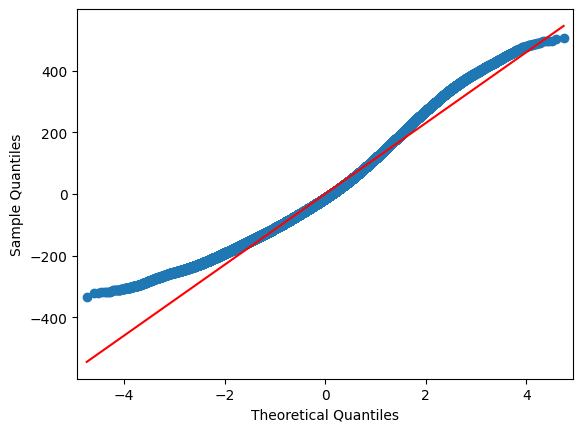

In [52]:
sm.qqplot(results.resid, line="s")

##### VIF

In [56]:
vif_data = pd.DataFrame()
vif_data["feature"] = x_train.columns

# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(x_train.values, i) for i in range(len(x_train.columns))]
vif_data

,feature,VIF
0,ORIGIN_AIRPORT_ID,13.190342
1,DEST_AIRPORT_ID,14.401719
2,OPERATING_CARRIER,12.349817
3,PASSENGERS,1.238698
4,MARKET_DISTANCE,6.349855
5,MKT_GEO_TYPE_1,28.789132
6,ROUNDTRIP,3.751334
7,ONLINE,3.954250
8,TRIP_BREAK_1,3.021303
9,COUPON_TYPE_1,76.133269


In [57]:
# calculating VIF for each feature after dropping coupon type
x_train_vif = x_train.drop(['COUPON_TYPE_1'], axis=1)
vif_data = pd.DataFrame()
vif_data["feature"] = x_train_vif.columns

vif_data["VIF"] = [variance_inflation_factor(x_train_vif.values, i) for i in range(len(x_train_vif.columns))]
vif_data

,feature,VIF
0,ORIGIN_AIRPORT_ID,10.718509
1,DEST_AIRPORT_ID,11.364147
2,OPERATING_CARRIER,11.793531
3,PASSENGERS,1.238673
4,MARKET_DISTANCE,6.311468
5,MKT_GEO_TYPE_1,12.931135
6,ROUNDTRIP,3.625987
7,ONLINE,3.883772
8,TRIP_BREAK_1,2.948137
9,FARE_CLASS,1.120148


In [58]:
# Retrain the model to check for improvements
X = sm.add_constant(x_train_vif)
ols = sm.OLS(y_train, X)
results = ols.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            MARKET_FARE   R-squared:                       0.395
Model:                            OLS   Adj. R-squared:                  0.395
Method:                 Least Squares   F-statistic:                 6.084e+04
Date:                Mon, 28 Nov 2022   Prob (F-statistic):               0.00
Time:                        13:46:11   Log-Likelihood:            -5.7547e+06
No. Observations:              933547   AIC:                         1.151e+07
Df Residuals:                  933536   BIC:                         1.151e+07
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                79.6293      1.045     76.193      0.000      77.581      81.678
ORIGIN_AIRPORT_ID   430.6674      2.894    148.810      0.000     424.995     436.340
DEST_AIRPORT_ID     465.0604      3.225    144.209      0.000     458.740     471.381
OPERATING_CARRIER    -5.0463      0.440    -11.459      0.000      -5.909      -4.183
PASSENGERS          -73.9645      0.870    -84.975      0.000     -75.671     -72.259
MARKET_DISTANCE     278.2964      0.969    287.104      0.000     276.397     280.196
MKT_GEO_TYPE_1       51.6417      0.656     78.772      0.000      50.357      52.927
ROUNDTRIP           -14.5763      0.271    -53.788      0.000     -15.107     -14.045
ONLINE              -13.0885      0.290    -45.156      0.000     -13.657     -12.520
TRIP_BREAK_1         -9.5401      0.302    -31.636      0.000     -10.131      -8.949
FARE_CLASS          256.3270      0.484    530.117      0.000     255.379     257.275
==============================================================================
Omnibus:                    50464.902   Durbin-Watson:                   1.996
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            59056.920
Skew:                           0.601   Prob(JB):                         0.00
Kurtosis:                       3.275   Cond. No.                         60.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [59]:
X_test = sm.add_constant(x_test.drop(['COUPON_TYPE_1'], axis=1))
ols_preds = results.predict(X_test)
print(np.sqrt(mean_squared_error(y_test, ols_preds)))
print(np.sqrt(mean_squared_error(y_train, results.fittedvalues)))

114.78637109997099
115.0480178862055


<AxesSubplot: >

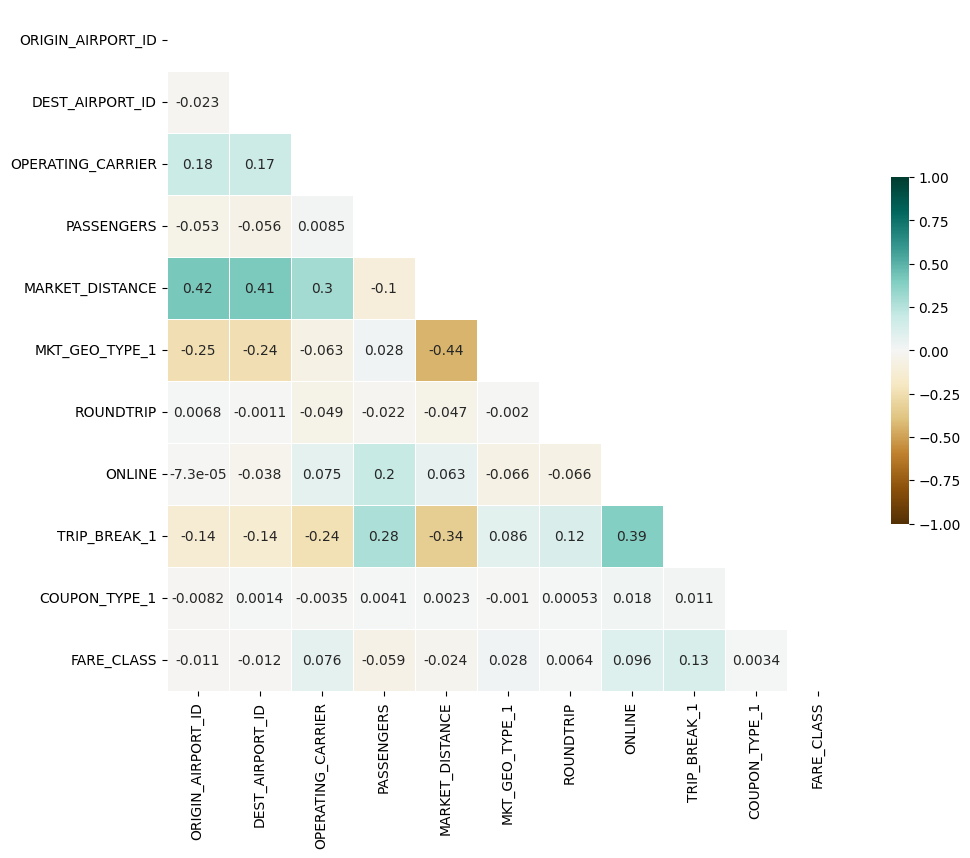

In [41]:
# Check correlation matrix again
cor_df = x_train.corr()
mask = np.triu(np.ones_like(cor_df, dtype=bool))
f, ax = plt.subplots(figsize=(11, 9))
#cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(cor_df, mask=mask, cmap='BrBG', vmin=-1, vmax=1, center=0, annot=True,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

##### Residuals vs Fitted

In [79]:
fitted = results.predict(X)
resid_df = pd.DataFrame(fitted.tolist(), columns=['Fitted'])
resid_df['Residuals'] = results.resid.tolist()
sns.scatterplot(y='Residuals', x='Fitted', data=resid_df, s=4)

C:\Users\shash\AppData\Local\Temp\ipykernel_7120\2236102997.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(results.resid, bins=50 )


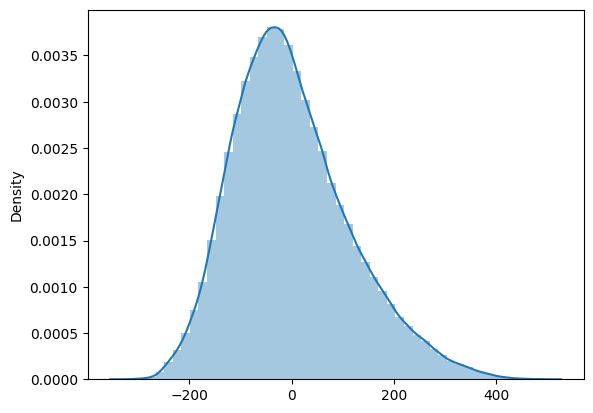

In [84]:
# histogram of residuals
sns.distplot(results.resid, bins=50)
plt.show()

##### Box-cox Tranformation

In [43]:
y_box = scipy.stats.boxcox(y_train)
y_box[1] # get the best lambda value

0.18571794780231388

In [44]:
# Convert response based on best lambda value obtained
y_train_box = np.power(y_train, y_box[1])

# Retrain the model
X = sm.add_constant(x_train)
ols = sm.OLS(y_train_box, X)
results_box = ols.fit()
results_box.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            MARKET_FARE   R-squared:                       0.354
Model:                            OLS   Adj. R-squared:                  0.354
Method:                 Least Squares   F-statistic:                 4.647e+04
Date:                Sun, 27 Nov 2022   Prob (F-statistic):               0.00
Time:                        18:31:18   Log-Likelihood:             1.5171e+05
No. Observations:              933547   AIC:                        -3.034e+05
Df Residuals:                  933535   BIC:                        -3.033e+05
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 2.1427      0.017    124.979      0.000       2.109       2.176
ORIGIN_AIRPORT_ID     0.7625      0.005    147.378      0.000       0.752       0.773
DEST_AIRPORT_ID       0.8306      0.006    144.061      0.000       0.819       0.842
OPERATING_CARRIER     0.0051      0.001      6.524      0.000       0.004       0.007
PASSENGERS           -0.1400      0.002    -89.978      0.000      -0.143      -0.137
MARKET_DISTANCE       0.4646      0.002    268.089      0.000       0.461       0.468
MKT_GEO_TYPE_1        0.0863      0.001     73.620      0.000       0.084       0.089
ROUNDTRIP            -0.0168      0.000    -34.720      0.000      -0.018      -0.016
ONLINE               -0.0205      0.001    -39.546      0.000      -0.022      -0.019
TRIP_BREAK_1         -0.0245      0.001    -45.484      0.000      -0.026      -0.023
COUPON_TYPE_1        -0.0866      0.017     -5.089      0.000      -0.120      -0.053
FARE_CLASS            0.0014    3.2e-06    442.303      0.000       0.001       0.001
==============================================================================
Omnibus:                     2930.065   Durbin-Watson:                   1.996
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2808.884
Skew:                          -0.113   Prob(JB):                         0.00
Kurtosis:                       2.855   Cond. No.                     3.41e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.41e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [47]:
fitted = results_box.predict(X)
resid_df = pd.DataFrame(fitted.tolist(), columns=['Fitted'])
resid_df['Residuals'] = results_box.resid.tolist()
sm.qqplot(results_box.resid, line="s")

<AxesSubplot: xlabel='Fitted', ylabel='Residuals'>

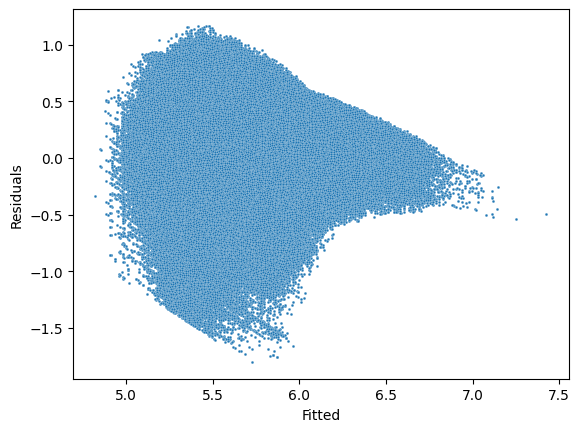

In [50]:
# Check residuals vs fitted plot after transformation
y_train_log = np.log(y_train)
X = sm.add_constant(x_train)
ols = sm.OLS(y_train_log, X)
results_log = ols.fit()
results_log.summary()

fitted = results_log.predict(X)
resid_df = pd.DataFrame(fitted.tolist(), columns=['Fitted'])
resid_df['Residuals'] = results_log.resid.tolist()
sns.scatterplot(y='Residuals', x='Fitted', data=resid_df, s=4)

##### F Test 

In [83]:
A = np.identity(len(results.params))
A = A[1:,:]
print(results.f_test(A))
print("F Crit: ", scipy.stats.f.ppf(q=1-.05, dfn=x_train.shape[1], dfd=x_train.shape[0]))

<F test: F=55309.44825708813, p=0.0, df_denom=9.34e+05, df_num=11>
F Crit:  1.7886590967880884


#### Ridge Regression

In [86]:
# This part is run in R. Please refer to the ridge_regression.R file
x_csv = pd.DataFrame(x_train)
y_csv = pd.DataFrame(y_train)
x_test_csv = pd.DataFrame(x_test)

x_test_csv = pd.DataFrame(x_test)
x_test_csv.to_csv("x_test.csv")
y_test_csv = pd.DataFrame(y_test)
y_test_csv.to_csv("y_test.csv")
x_csv.to_csv("x.csv")
y_csv.to_csv("y.csv")

#### Random Forests

In [75]:
rf = RandomForestRegressor(n_estimators=100,
                           max_depth=10,
                           min_samples_split=50,
                           n_jobs=-1,
                           random_state=10
                          )

# parameters for hyperparameter tuning
param_grid = {
             "n_estimators": [50,100],
              "min_samples_split": [50, 500],
              "max_depth": [5,10]
                #"max_features": [None, 'auto']
              }

In [77]:
# Grid search for best hyperparameters
gs = GridSearchCV(
    estimator=rf, 
    param_grid=param_grid,
    cv=3,
    refit=True,
    verbose=True,
    n_jobs=-1)
gs.fit(x_train, y_train)
gs.best_params_

Fitting 3 folds for each of 8 candidates, totalling 24 fits


GridSearchCV(cv=3,
             estimator=RandomForestRegressor(max_depth=10, min_samples_split=50,
                                             n_jobs=-1, random_state=10),
             n_jobs=-1,
             param_grid={'max_depth': [5, 10], 'min_samples_split': [50, 500],
                         'n_estimators': [50, 100]},
             verbose=True)

In [ ]:
# Fit the model with best hyperparameters
rf = RandomForestRegressor(n_estimators=100,
                           max_depth=10,
                           min_samples_split=50,
                           n_jobs=-1,
                           random_state=10
                          )
rf.fit(x_train, y_train)
rf_preds = rf.predict(x_test)


In [90]:
# Find RMSE and R-squared
print(np.sqrt(mean_squared_error(y_train, rf.predict(x_train))))
print(np.sqrt(mean_squared_error(y_test, rf_preds)))
fitted = rf.predict(x_train)
rf_Rsq = 1 - sum(np.power((y_train - fitted),2))/sum(np.power((y_train - np.mean(y_train)),2))
print(rf_Rsq)

0.43046448314735153

In [43]:
# Get variable importance
fi = pd.DataFrame(x_train.columns, columns=['Feature'])
fi['Val'] = rf.feature_importances_
fi.sort_values(by='Val')

,Feature,Val
10,COUPON_TYPE_1,0.000000
2,OPERATING_CARRIER,0.000800
5,MKT_GEO_TYPE_1,0.002241
6,ORIGIN_STATE_ABR,0.004709
8,ONLINE,0.005560
7,ROUNDTRIP,0.005731
9,TRIP_BREAK_1,0.006493
3,PASSENGERS,0.026725
0,ORIGIN_AIRPORT_ID,0.035409
1,DEST_AIRPORT_ID,0.041953


#### XGBoost

In [ ]:
# parameters for hyperparameter tuning
param_grid = {
             "n_estimators": [50,100],
              "eta": [0.1, 0.01],
              "max_depth": [5,10]
                #"max_features": [None, 'auto']
              }
gs = GridSearchCV(
    estimator=xgb, 
    param_grid=param_grid,
    cv=3,
    refit=True,
    verbose=True,
    n_jobs=-1)
gs.fit(x_train, y_train)
gs.best_params_

Fitting 3 folds for each of 8 candidates, totalling 24 fits


In [ ]:
# Use best hyperparameters for fitting the model
xgb = XGBRegressor(n_estimators=100,
                  max_depth = 10,
                   eta=0.1,
                   subsample=0.7,
                   colsample_bytree=0.8,
                   n_jobs=-1,
                   eval_metric=mean_squared_error
                  )
xgb.fit(x_train, y_train)

In [155]:
xgb_preds = xgb.predict(x_test)
print(np.sqrt(mean_squared_error(y_train, xgb.predict(x_train))))
print(np.sqrt(mean_squared_error(y_test, xgb_preds)))
fitted = xgb.predict(x_train)
xgb_Rsq = 1 - sum(np.power((y_train - fitted),2))/sum(np.power((y_train - np.mean(y_train)),2))
print(xgb_Rsq)

107.86427847506879
109.53305067338998


#### MLP

In [60]:
# Split train into train and validation datasets
x_train1, x_val, y_train1, y_val = train_test_split(x_train, y_train, test_size=x_test.shape[0], random_state=100)

In [70]:
# Define parameters
epochs=70
batch_size = int(x_train.shape[0]/30)
loss = tf.keras.losses.MeanSquaredError()
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
#opt = tf.keras.optimizers.SGD(learning_rate=0.0001, momentum=0.9, nesterov=True)
metric = tf.keras.metrics.RootMeanSquaredError()
activation_fn = 'relu'

In [71]:
# Build the network
start = layers.Input(shape=x_train.shape[1])
model = layers.Dense(128, activation=activation_fn, kernel_regularizer=regularizers.l2(0.01))(start)
model = layers.Dense(64, activation=activation_fn, kernel_regularizer=regularizers.l2(0.01))(model)
model = layers.Dense(16, activation=activation_fn, kernel_regularizer=regularizers.l2(0.01))(model)
out = layers.Dense(1)(model)
nn = Model(inputs=start, outputs=out)

In [63]:
# Compile and fit the model
nn.compile(loss=loss, optimizer=opt, metrics=metric)
nn.fit(x_train1, y_train1, epochs=epochs, batch_size=batch_size, validation_data=(x_val, y_val))

Epoch 1/70
23/23 [==============================] - 4s 37ms/step - loss: 117491.7344 - root_mean_squared_error: 342.7688 - val_loss: 116451.6250 - val_root_mean_squared_error: 341.2483
Epoch 2/70
23/23 [==============================] - 0s 11ms/step - loss: 115611.7734 - root_mean_squared_error: 340.0155 - val_loss: 112702.3359 - val_root_mean_squared_error: 335.7098
Epoch 3/70
23/23 [==============================] - 0s 11ms/step - loss: 107822.6172 - root_mean_squared_error: 328.3615 - val_loss: 98339.4844 - val_root_mean_squared_error: 313.5890
Epoch 4/70
23/23 [==============================] - 0s 11ms/step - loss: 84257.0078 - root_mean_squared_error: 290.2679 - val_loss: 63543.7305 - val_root_mean_squared_error: 252.0753
Epoch 5/70
23/23 [==============================] - 0s 11ms/step - loss: 44398.1055 - root_mean_squared_error: 210.7038 - val_loss: 26651.3340 - val_root_mean_squared_error: 163.2454
Epoch 6/70
23/23 [==============================] - 0s 12ms/step - loss: 23737.3

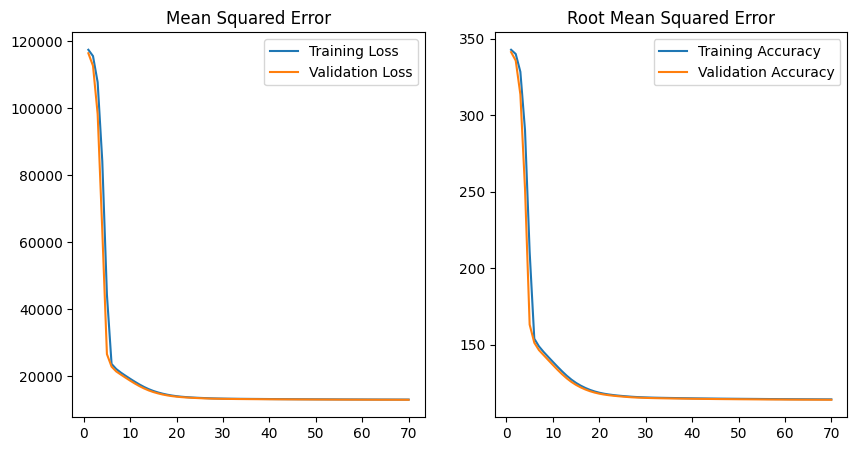

In [67]:
# Plot the losses
hist_res = nn.history.history
mse = hist_res['root_mean_squared_error']
val_mse = hist_res['val_root_mean_squared_error']
loss = hist_res['loss']
val_loss = hist_res['val_loss']

epochs_list=range(1, len(loss)+1)

fig, ax = plt.subplots(1,2, figsize=(10, 5), squeeze=False)
axli = ax.flatten()
sns.lineplot(x=epochs_list, y=loss, ax=axli[0], legend='brief', label="Training Loss")
sns.lineplot(x=epochs_list, y=val_loss, ax=axli[0], legend='brief', label="Validation Loss")
axli[0].set_title("Mean Squared Error")

sns.lineplot(x=epochs_list, y=mse, ax=axli[1], legend='brief', label="Training Accuracy")
sns.lineplot(x=epochs_list, y=val_mse, ax=axli[1], legend='brief', label="Validation Accuracy")
axli[1].set_title("Root Mean Squared Error")
plt.show()

In [72]:
# Retrain with train and validation datasets
start = layers.Input(shape=x_train.shape[1])
model = layers.Dense(128, activation=activation_fn, kernel_regularizer=regularizers.l2(0.01))(start)
model = layers.Dense(64, activation=activation_fn, kernel_regularizer=regularizers.l2(0.01))(model)
model = layers.Dense(16, activation=activation_fn, kernel_regularizer=regularizers.l2(0.01))(model)
out = layers.Dense(1)(model)
nn = Model(inputs=start, outputs=out)

nn.compile(loss=loss, optimizer=opt, metrics=metric)
nn.fit(x_train, y_train, epochs=20, batch_size=batch_size, validation_data=(x_val, y_val))

Epoch 1/20
23/23 [==============================] - 1s 23ms/step - loss: 117361.8203 - root_mean_squared_error: 342.5793 - val_loss: 116215.8594 - val_root_mean_squared_error: 340.9027
Epoch 2/20
23/23 [==============================] - 0s 11ms/step - loss: 115001.8906 - root_mean_squared_error: 339.1175 - val_loss: 111460.0781 - val_root_mean_squared_error: 333.8546
Epoch 3/20
23/23 [==============================] - 0s 10ms/step - loss: 105500.5234 - root_mean_squared_error: 324.8065 - val_loss: 94388.1953 - val_root_mean_squared_error: 307.2244
Epoch 4/20
23/23 [==============================] - 0s 10ms/step - loss: 78308.1484 - root_mean_squared_error: 279.8332 - val_loss: 55587.2539 - val_root_mean_squared_error: 235.7657
Epoch 5/20
23/23 [==============================] - 0s 10ms/step - loss: 37348.4102 - root_mean_squared_error: 193.2521 - val_loss: 23463.1094 - val_root_mean_squared_error: 153.1693
Epoch 6/20
23/23 [==============================] - 0s 11ms/step - loss: 22890.6

In [73]:
mlp_preds = nn.predict(x_test)
print(np.sqrt(mean_squared_error(y_train, nn.predict(x_train))))
print(np.sqrt(mean_squared_error(y_test, mlp_preds)))
fitted = np.squeeze(nn.predict(x_train))
mlp_Rsq = 1 - sum(np.power((y_train - fitted),2))/sum(np.power((y_train - np.mean(y_train)),2))
print(mlp_Rsq)

118.17238030595085
117.9632392647603


### Appendix (Unused Codes)

#### WLS

#### LAD

#### Other codes

#### OHE